In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

/home/jeonko/anaconda3/envs/spc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualize Weights

## Data

데이터셋 불러오기
- (Data, Label ,VQ) 쌍을 불러온다.

In [45]:
from dataloader.utils import load_dataset
# wav_root = '/home/nas4/DB/fluent_speech_commands/fluent_speech_commands_dataset'
# pt_root = '/home/fluent_speech_commands/fluent_speech_commands_dataset'
# testing_dataset, test_collate_fn = load_dataset(data_name= 'fluent',
#                                                   root= f'{pt_root}_xlsr_mean',
#                                                   vq_root= f'{pt_root}_xlsr_vq',
#                                                   subset='testing',
#                                                   ext='pt', get_collate_fn=True)

wav_root = '/home/nas3/user/jeonko/spc_embedding/data/SpeechCommands/speech_commands_v0.02'
root = '/home/SpeechCommands'
testing_dataset, test_collate_fn = load_dataset(data_name='speechcommands',
                                                root=root,
                                                folder_in_archive= 'SpeechCommands_xlsr_mean',
                                                vq_folder= 'SpeechCommands_xlsr_vq',
                                                url= 'speech_commands_v0.02',
                                                subset= 'testing',
                                                ext='pt', get_collate_fn=True)

In [51]:
import torchaudio

idx = 0
data, label, vq = testing_dataset[idx]
# wav_path, _, _, _, _, _, _, _ = testing_dataset.get_metadata(idx) # Fluent_speech
# wav, sr = torchaudio.load(f"{wav_root}/{wav_path.replace('.pt','.wav')}")
wav_path = testing_dataset.get_idx_path(idx)
wav, sr = torchaudio.load(f"{wav_root}/{'/'.join(wav_path.split('/')[-2:]).replace('.pt','.wav')}")
print("DATA SIZE:", data.shape)
print("VQ SIZE  :", vq.shape)

DATA SIZE: torch.Size([1, 49, 1024])
VQ SIZE  : torch.Size([49, 2])


Pooing 방법 불러오기

In [52]:
from models.aggregate import VQLocalProbAvgPool, SelfAttentiveMaskingPooling
VQ_Pooler = VQLocalProbAvgPool()
SA_Pooler = SelfAttentiveMaskingPooling(1024)

# ====
# 학습된 모델 불러오기
# ====
# checkpoint = '/home/nas/user/hhj/spc_embedding/exp_xlsr/ic/xlsr_sap/ic_xlsr/lightning_logs/version_0/checkpoints/AVG-SpeechCommandsV2-epoch=36-val_loss=0.20-val_ACC=94.58.ckpt'
checkpoint = '/home/nas/user/hhj/spc_embedding/exp_xlsr/kws/xlsr_sap/kws_xlsr/lightning_logs/version_0/checkpoints/AVG-SpeechCommandsV2-epoch=182-val_loss=0.14-val_ACC=97.53.ckpt'
states = torch.load(checkpoint, map_location='cpu')
sap_state_dict = {key.replace('model.head.', ''):value for key, value in states['state_dict'].items() if 'model.head' in key}
SA_Pooler.load_state_dict(sap_state_dict)

<All keys matched successfully>

In [53]:
#======
# 우리 Pooler들은 Batch 단위로 입력받으니까 unsqueeze가 필요하다.
#======
data_ = data.unsqueeze(0)
vq_ = vq.unsqueeze(0)
#======
# 길이를 tensor로 뽑아줌.
#======
data_length = torch.tensor([data.size(1)])

#======
# 우리 Pooler는 반드시 get_weight 메소드를 갖게 구현하자.
#======
temporal_weights_1 = VQ_Pooler.get_weight(data_, data_length, vq_).squeeze() # Drop 1st dim (batch dim)
temporal_weights_2 = SA_Pooler.get_weight(data_, data_length, vq_).squeeze().detach().cpu().numpy()

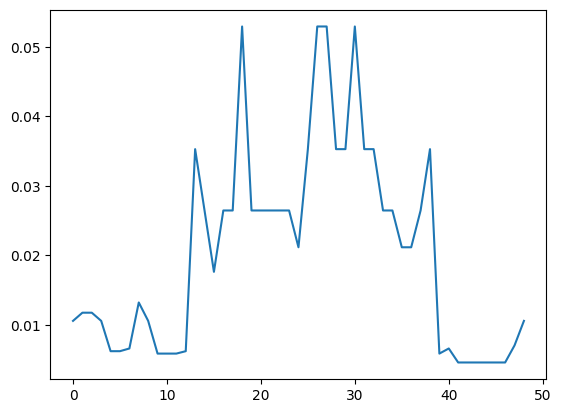

In [56]:
plt.plot(temporal_weights_1)
# plt.plot(temporal_weights_2)
plt.show()

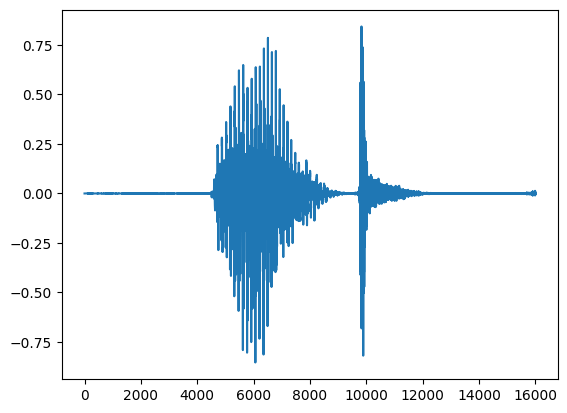

In [55]:
plt.plot(wav.squeeze())
plt.show()